# Gradient Boosting Machines Spam Detection Model

In [1]:
import pandas as pd
import numpy as np
import re
import email
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import recmetrics
from sklearn.metrics import confusion_matrix

In [2]:
def get_email_text_from_string(string):
    email_obj = email.message_from_string(string)
    content = []
    for part in email_obj.walk():
        if part.get_content_type() == 'text/plain':
            content.append(part.get_payload())
    return ' '.join(content)

def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

## Load and Format Class 0 emails

In [3]:
#Load email data
enron_emails = pd.read_csv('data/emails.csv')

#Format emails
enron_emails["content"] = enron_emails.message.apply(get_email_text_from_string)

enron_emails["content"] = enron_emails.content.apply(func=remove_punctuation)
enron_emails["content"] = enron_emails.content.apply(func=make_lower_case)
enron_emails["content"] =  enron_emails.content.str.replace("\n", " ")
enron_emails["content"] =  enron_emails.content.str.replace("-", "")

#Downsample
enron_emails = enron_emails.sample(5000)
enron_emails.reset_index(drop=True, inplace=True)

# Show example email
print enron_emails.shape
n = np.random.randint(low=0, high=len(enron_emails))
print enron_emails.content[n]

(5000, 3)
it is amazing and yet not surprising how much enron has accomplished in the 20 first six months of this year you continue to make it happen we recogniz e 20 that you work hard every day to accomplish enron 01 s business goals and w e are 20 pleased that many of you have shared in the company 01 s financial success 20 through enron stock options 20 as you may know the current employee stock option program also known as t he 20 all employee stock option program or aesop began in 1994 and provided valu e 20 to participants through 2000 employees who have participated in this 20 program from its inception have realized a 1 119 increase in the value of 20 their stock options assuming a stock price of 70 over the life of the 20 program 20 enron stock options are a valuable part of your total compensation package 20 and a contributing factor to your performance and to enron 01 s continued 20 success therefore the enron executive committee and the compensation and 20 management devel

## Load and Format Class Spam Emails

In [4]:
#Load frad email data
file_name = open("data/fradulent_emails.txt","rt")
fraud_emails = ''
for line in file_name:
    fraud_emails = fraud_emails + ' ' + line

#format emails and extract body
fraud_emails = fraud_emails.split(" From r  ")
fraud_emails = fraud_emails[1:]

def get_fraud_email_body(string):
    try:
        return string.split(" Status: ",1)[1].decode('ascii')
    except:
        pass
    
fraud_emails = [get_fraud_email_body(string) for string in fraud_emails]
fraud_emails = pd.Series(fraud_emails)
fraud_emails.dropna(inplace=True)

fraud_emails = fraud_emails.apply(func=remove_punctuation)
fraud_emails = fraud_emails.apply(func=make_lower_case)
fraud_emails = fraud_emails.str.replace(r"^o ", "")
fraud_emails = fraud_emails.str.replace(r"^ro ", "")

print fraud_emails.shape
fraud_emails.head()

(3615,)


0    from mr james ngola confidential tel 233 27 58...
1    dear friend i am mr ben suleman a custom offic...
2    from his royal majesty hrm crown ruler of elem...
3    from his royal majesty hrm crown ruler of elem...
4    dear sir it is with a heart full of hope that ...
dtype: object

In [5]:
#Show example email
n = np.random.randint(low=0, high=len(fraud_emails))
fraud_emails[n]

u'strictly confidential please idris adamu nnpc 2c ikoyi lagos nigeria email 3a idris 5fadamu 40africamail 2ecom fax 3a 234 1 4401017 4 2f12 2f2003 attention 3a the president 2fchairman proposal for transfer of twenty million 2c five hundred thousand us dollars 28us 20 2e5m 29 to your account 2e your contact address got to me via export promotions council 2c your reliability and trustworthiness in business transaction was the main conviction that compelled me to solicit for your support in this deal 2e i am the financial controller of the nigerian national petroleum corporation 28nnpc 29 lagos 2c nigeria and secretary to the contract award committee of my ministry 2e in collaboration with my colleagues 2c we have agreed to transfer out of the country through central bank of nigeria 28cbn 29 some amount and we will later reinvest it abroad after the success of this transaction 2e the amount involved is twenty million 2c five hundred thousand us dollars 28us 20 2c500 2c000 2e00 29 2e thi

# Create tagged data

In [6]:
all_emails = enron_emails.content.tolist()
all_emails.extend(fraud_emails)
all_emails = pd.DataFrame(all_emails)
all_emails.columns = ["email"]
all_emails["class"] = 0
all_emails.loc[all_emails.index > 5000, "class"] = 1
print all_emails.shape
all_emails.head()

(8615, 2)


,email,class
0,press coverage summary gop power plan doc rich...,0
1,andy this is to confirm that the engineering d...,0
2,kim can you set up the meeting with my people ...,0
3,thanks and have a great holiday m,0
4,hi guys is the lv co gen break out contract re...,0


# Test Train Split

In [7]:
emails_train, emails_test, y_train, y_test = train_test_split(all_emails["email"], 
                                                              all_emails["class"], 
                                                              test_size=0.33, 
                                                              random_state=0)
print "{} training observations".format(emails_train.shape[0])
print "{} testing observations".format(emails_test.shape[0])

5772 training observations
2843 testing observations


# Feature Engineering

In [8]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=1000,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=25)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(emails_train)
X_train = svd.fit_transform(tfidf_matrix)

#Transform test data
tfidf_matrix = tf.transform(emails_test)
X_test = svd.transform(tfidf_matrix)

# Gradient Boosting Machines Models

## Sklearn Gradient Boosting Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [1000], 'max_depth': [3, 5, 10], 'subsample': [1],
          'learning_rate': [0.01], 'min_samples_leaf': [1]}
gbt = GradientBoostingClassifier(random_state=0)
clf = GridSearchCV(gbt, params, cv=5)
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [ ]:
#check for overfitting
acc = clf.score(X_train, y_train)
print("Train Accuracy: {:.4f}".format(acc))
acc = clf.score(X_test, y_test)
print("Test Accuracy: {:.4f}".format(acc))

In [ ]:
#Check confusion matrix
pred_test = clf.predict(X_test)
cm = confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

In [ ]:
class_probs = clf.predict_proba(X_test)[:,1]
model_probs = [class_probs]
model_names = ["GBT"]
recmetrics.ROCPlot(y_test, model_probs, model_names)

# XGBoost

In [28]:
import xgboost as xgb

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [34]:
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [35]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-auc:0.986022	train-auc:0.984395
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 10 rounds.
[1]	eval-auc:0.991973	train-auc:0.991833
[2]	eval-auc:0.994622	train-auc:0.994939
[3]	eval-auc:0.996259	train-auc:0.997091
[4]	eval-auc:0.996612	train-auc:0.997519
[5]	eval-auc:0.996902	train-auc:0.997899
[6]	eval-auc:0.997573	train-auc:0.998329
[7]	eval-auc:0.997701	train-auc:0.998627
[8]	eval-auc:0.997826	train-auc:0.998961
[9]	eval-auc:0.997924	train-auc:0.999079


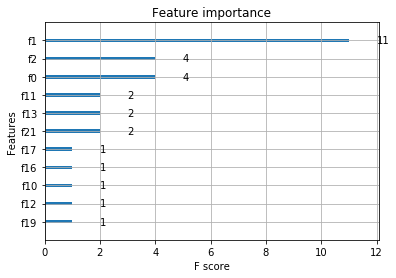

In [36]:
xgb.plot_importance(bst)

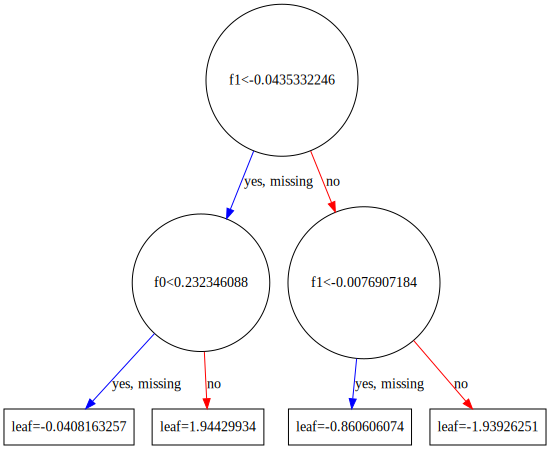

In [40]:
xgb.to_graphviz(bst, num_trees=0)

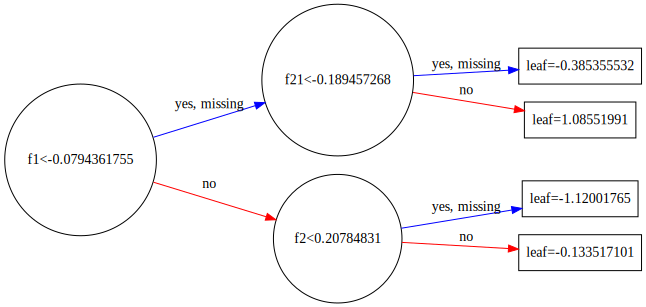

In [38]:
xgb.to_graphviz(bst, num_trees=1, rankdir='LR')

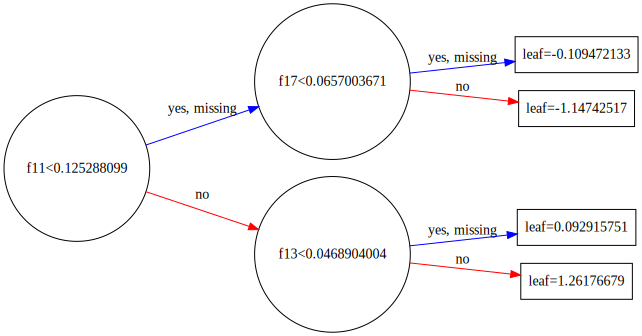

In [39]:
xgb.to_graphviz(bst, num_trees=5, rankdir='LR')

In [41]:
print bst.eval(dtrain)
print bst.eval(dtest)

[0]	eval-auc:0.999079
[0]	eval-auc:0.997924


In [42]:
#Check confusion matrix
pred_test = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
pred_test[pred_test>=0.5]=1
pred_test[pred_test<0.5]=0
cm = confusion_matrix(y_test, pred_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm

array([[0.99141631, 0.00858369],
       [0.02145215, 0.97854785]])

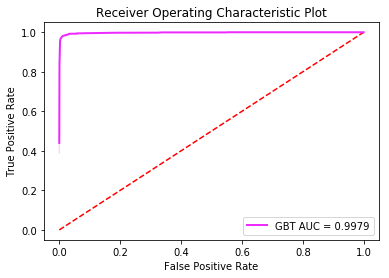

In [43]:
class_probs = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
model_probs = [class_probs]
model_names = ["GBT"]
recmetrics.ROCPlot(y_test, model_probs, model_names)